<a href="https://colab.research.google.com/github/Datasci266-Final-Project/Job-Listings/blob/main/Model%20Training%20Notebooks/Model_1_Trainer_xlm_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs

!pip install pydot --quiet
!pip install transformers==4.37.2 --quiet
!pip install -U imbalanced-learn --quiet

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [ ]:
#@title Imports
import pandas as pd

import numpy as np
import random
import torch

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertModel, AutoTokenizer, TFXLMRobertaModel #"FacebookAI/xlm-roberta-base"

from transformers import logging
logging.set_verbosity_error()

from collections import Counter

import pickle

In [ ]:
# Set seed to 10

seed_value = 10

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/DataSci 266 Project

column_names = ['index','title','text','level','salary']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1V3QooLePiHR_DaZhbXQhsjmP1Ez5fv5F/DataSci 266 Project


In [ ]:
pd.set_option('display.max_colwidth', 10000)

In [ ]:
# Dictionaries
level_key = {
    "student_intern": 0,
    "entry": 1,
    "junior": 2,
    "mid": 3,
    "senior": 4,
    "executive": 5,
    np.nan: -1
}

# Define salary_key dictionary
salary_key = {
    "<45k": 0,
    "45-65k": 1,
    "65-85k": 2,
    "85-110k": 3,
    "110-150k": 4,
    "150-200k": 5,
    ">200k": 6,
    np.nan: -1
}


In [ ]:
#@title Import Tokens, Labels, Data

# data
with open(r'Model Objects/train_final_df.pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open(r'Model Objects/test_data.pickle', 'rb') as handle:
    test_data = pickle.load(handle)
with open(r'Model Objects/val_data.pickle', 'rb') as handle:
    val_data = pickle.load(handle)


# labels
with open(r'Model Objects/Labels/labels_level_train_baseline.pickle', 'rb') as handle:
    train_level_labels = pickle.load(handle)

with open(r'Model Objects/Labels/labels_salary_train_baseline.pickle', 'rb') as handle:
    train_salary_labels = pickle.load(handle)


with open(r'Model Objects/Labels/labels_level_test_baseline.pickle', 'rb') as handle:
    test_level_labels = pickle.load(handle)

with open(r'Model Objects/Labels/labels_salary_test_baseline.pickle', 'rb') as handle:
    test_salary_labels = pickle.load(handle)


with open(r'Model Objects/Labels/labels_level_val_baseline.pickle', 'rb') as handle:
    val_level_labels = pickle.load(handle)

with open(r'Model Objects/Labels/labels_salary_val_baseline.pickle', 'rb') as handle:
    val_salary_labels = pickle.load(handle)


# tokenized inputs
with open(r'Model Objects/Tokenized Inputs: xlm-RoBERTa/train_inputs_xlm_roberta.pickle', 'rb') as handle:
    train_inputs = pickle.load(handle)

with open(r'Model Objects/Tokenized Inputs: xlm-RoBERTa/test_inputs_xlm_roberta.pickle', 'rb') as handle:
    test_inputs = pickle.load(handle)

with open(r'Model Objects/Tokenized Inputs: xlm-RoBERTa/val_inputs_xlm_roberta.pickle', 'rb') as handle:
    val_inputs = pickle.load(handle)

In [ ]:
#@title xlm-RoBERTa

checkpoint = "FacebookAI/xlm-roberta-base"
xlm_roberta_model = TFXLMRobertaModel.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
MAX_SEQUENCE_LENGTH = 512

In [ ]:
#@title Define Model

# Masked Loss Function
def masked_loss_function(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, -1))  # Use -1 to represent missing values
    mask = tf.cast(mask, tf.float32)

    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32 to match the type of y_pred
    y_pred = tf.cast(y_pred, tf.float32)

    return tf.keras.losses.sparse_categorical_crossentropy(y_true * mask, y_pred * mask)




# BERT Model
def create_xlm_roberta_multi_output_model(xlm_roberta_base_model,
                                   trainable=True,
                                 max_sequence_length=MAX_SEQUENCE_LENGTH,
                                   num_level_classes=7,
                                   num_salary_classes=8,
                                 base_hidden_size=100,
                                  level_hidden_size=100,
                                  salary_hidden_size=100,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                   LEVEL_WEIGHT=0.5,
                                   SALARY_WEIGHT=0.5):

    xlm_roberta_base_model.trainable = trainable

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    xlm_roberta_inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    xlm_roberta_out = xlm_roberta_base_model(xlm_roberta_inputs)

    cls_token = xlm_roberta_out[0][:, 0, :]  # Extract CLS token
    # pooler_token = xlm_roberta_out[1]

    base_hidden = tf.keras.layers.Dense(base_hidden_size, activation='relu', name='base_hidden_layer_1')(cls_token)
    base_out = tf.keras.layers.Dropout(dropout)(base_hidden)

    # job experience level
    level_hidden = tf.keras.layers.Dense(level_hidden_size, activation='relu', name='level_hidden_layer_1')(base_out)
    level_hidden = tf.keras.layers.Dropout(dropout)(level_hidden)
    level_classification = tf.keras.layers.Dense(num_level_classes, activation='softmax', name='level_classification')(level_hidden)

    # salary bucket
    salary_hidden = tf.keras.layers.Dense(salary_hidden_size, activation='relu', name='salary_hidden_layer_1')(base_out)
    salary_hidden = tf.keras.layers.Dropout(dropout)(salary_hidden)
    salary_classification = tf.keras.layers.Dense(num_salary_classes, activation='softmax', name='salary_classification')(salary_hidden)



    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask],
                                          outputs=[level_classification, salary_classification])


    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss={'level_classification': masked_loss_function,
                                       'salary_classification': masked_loss_function},
                                 loss_weights=[LEVEL_WEIGHT,
                                               SALARY_WEIGHT],
                                 metrics={'level_classification': 'accuracy',
                                          'salary_classification': 'accuracy'})

    return classification_model




In [ ]:
#@title Create Model and Train - Take 1


# Fresh instance of BERT model
xlm_roberta_model = TFXLMRobertaModel.from_pretrained("FacebookAI/xlm-roberta-base")
multi_output_model = create_xlm_roberta_multi_output_model(xlm_roberta_model)


# Fit the model
multi_output_model_history = multi_output_model.fit(
    train_inputs,
    {"level_classification": train_level_labels, "salary_classification": train_salary_labels},
    validation_data=(val_inputs, {"level_classification": val_level_labels,"salary_classification": val_salary_labels}),
    batch_size=32,
    epochs=3,
    verbose=1,
    shuffle=True
)



Epoch 1/3


1789/1789 [==============================] - 1638s 891ms/step - loss: 1.8941 - level_classification_loss: 1.7153 - salary_classification_loss: 2.0730 - level_classification_accuracy: 0.2751 - salary_classification_accuracy: 0.0255 - val_loss: 1.9901 - val_level_classification_loss: 1.9178 - val_salary_classification_loss: 2.0624 - val_level_classification_accuracy: 0.0545 - val_salary_classification_accuracy: 0.0225
Epoch 2/3
1789/1789 [==============================] - 1588s 888ms/step - loss: 1.9500 - level_classification_loss: 1.8346 - salary_classification_loss: 2.0654 - level_classification_accuracy: 0.1632 - salary_classification_accuracy: 0.0242 - val_loss: 1.9815 - val_level_classification_loss: 1.9063 - val_salary_classification_loss: 2.0567 - val_level_classification_accuracy: 0.0185 - val_salary_classification_accuracy: 0.0210
Epoch 3/3
1789/1789 [==============================] - 1588s 887ms/step - loss: 1.9440 - level_classification_loss: 1.8246 - salary_classification_los

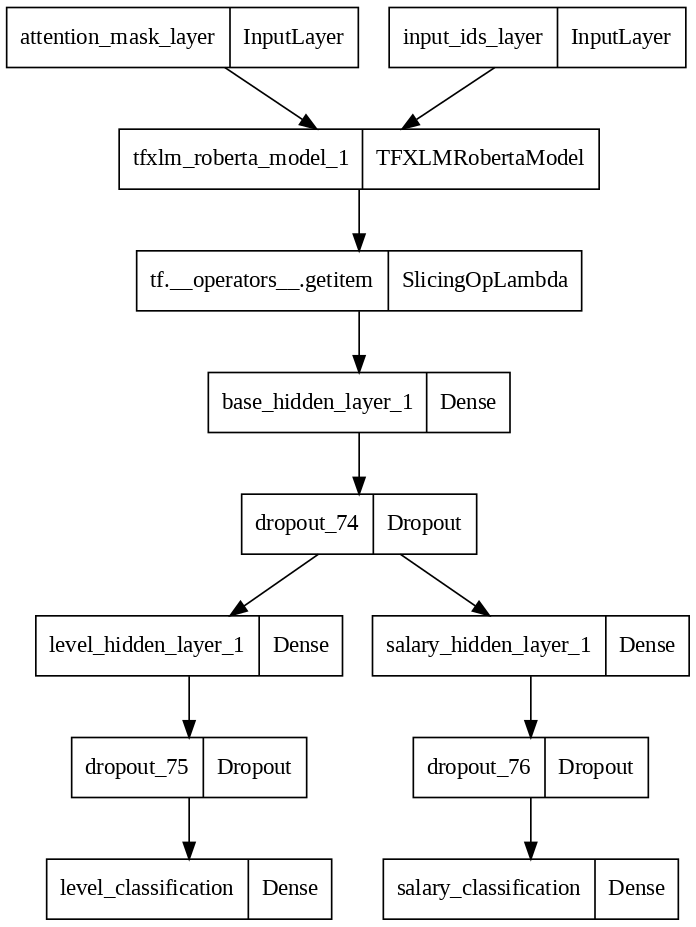

In [ ]:
keras.utils.plot_model(multi_output_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=120)

In [ ]:
#@title Export model weights


# export model weights
multi_output_model.save_weights('./model_1_xlm_roberta/model_1_xlm_roberta_weights')


